In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

using CairoMakie
using Random
using Printf
using DataFrames
using JLD
using StatsPlots
using LinearAlgebra
using NearestNeighbors
using DataInterpolations
using Clustering
using GraphMakie
using Graphs
using Distances
using BSON: @save
using ClusterValidityIndices
using Meshes
using StatsPlots

In [3]:
using PyCall

phate = pyimport("phate")

PyObject <module 'phate' from '/Users/boothh/.julia/conda/3/lib/python3.10/site-packages/phate/__init__.py'>

In [4]:
# example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))

# df = collect_results(datadir("sims/repeated_evolution_different_topologies"));

# df_current = filter(:n_traj=>x->x==2500,df);

# evolutionary_runs = Dict{String,Any}("classical"=>df_current[:,"raw_data"][1],"feed_forward"=>df_current[:,"raw_data"][2],"mutual_inh"=>df_current[:,"raw_data"][3],"overlap_dom"=>df_current[:,"raw_data"][4]);

In [5]:
# run_data = load(datadir("max_gen=20000_mutation_method=all_viable_n_traj=2500_noise_cv=1.0_noise_method=additive_topology=overlap_dom_β=Inf.jld2"))

# run_data = load(datadir("max_gen=20000_mutation_method=all_viable_n_traj=2500_noise_cv=1.0_noise_method=additive_topology=overlap_dom_β=0.0001.jld2"))

# run_data = load(datadir("sims/repeated_evolution_different_topologies/max_gen=20000_mutation_method=all_viable_n_traj=10000_noise_cv=1.0_noise_method=additive_start_network_name=c100_w60_topology=overlap_dom_β=Inf.jld2"))["raw_data"];

run_data = load(datadir("sims/repeated_evolution_different_topologies/max_gen=20000_mutation_method=all_viable_n_traj=20000_noise_cv=1.0_noise_method=additive_start_network_name=c100_w40_topology=overlap_dom_β=Inf.jld2"))["raw_data"];

In [6]:
# topology = "classical"

# start_network = example_networks[topology]
# run_data = evolutionary_runs[topology];

evo_traces = map(x->x[2],run_data);

In [7]:
function refresh_type(v)
    [i for i in v]
end

function attach_column_to_tuples(column::Vector{Float64},tuples::Vector{Tuple{Float64,Float64}})
    return hcat(column,hcat(first.(tuples), last.(tuples)))
end

function tuples_to_matrix(tuples::Vector{Tuple{Float64,Float64}})
    return hcat(first.(tuples), last.(tuples))
end

mutable struct PhenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    traj :: Vector{Vector{Tuple{Float64, Float64}}}
    traj_m ::Vector{Matrix{Float64}}

    initial_fitness :: Float64
    initial_phenotype :: Tuple{Float64,Float64}
    
    cluster_assignments :: Union{Vector{Int64}, Nothing}
    distance_mat ::  Union{Matrix{Float64},Nothing}

    max_clusters :: Union{Int64, Nothing}
    optimal_n_cluster :: Union{Int64, Nothing}
    criterion_values :: Union{Vector{Float64},Nothing}
    
    debug ::Any
end

mutable struct GenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    traj :: Vector{Vector{Matrix{Float64}}}
    traj_m ::Vector{Matrix{Float64}}

    initial_fitness :: Float64
    initial_genotype :: Vector{Float64}

    cluster_assignments :: Union{Vector{Int64}, Nothing}
    distance_mat ::  Union{Matrix{Float64},Nothing}

    max_clusters :: Union{Int64, Nothing}
    optimal_n_cluster :: Union{Int64, Nothing}
    criterion_values :: Union{Vector{Float64},Nothing}

    debug ::Any
end

################### Analysis constructors

function PhenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(unique(map(x->x[2],et.fitness_trajectory))),evo_traces)

    traj = map(et->refresh_type(unique(reduce(vcat,et.traversed_phenotypes))),evo_traces)

    traj_m = map(x->tuples_to_matrix(x) |> transpose |> collect,traj);

    initial_fitness = fitness_traj[1][1]
    initial_phenotype = traj[1][1]

    if initial_fitness < 0
        PhenoTrajectories(fitness_traj,traj,traj_m, initial_fitness, initial_phenotype,nothing,nothing,nothing,nothing,nothing,nothing)
    else
        fitness_traj = map(x-> -1 .* x,fitness_traj)
        PhenoTrajectories(fitness_traj,traj,traj_m, -initial_fitness, initial_phenotype,nothing,nothing,nothing,nothing,nothing,nothing)
    end

end

function GenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(unique(map(x->x[2],et.fitness_trajectory))),evo_traces)

    traj = map(et->unique(et.traversed_topologies),evo_traces);

    traj_m = map(tr->reduce(hcat,map(x->vec(x),tr)),traj)

    initial_fitness = fitness_traj[1][1]
    initial_genotype = vec(evo_traces[1].traversed_topologies[1])

    if initial_fitness < 0
        GenoTrajectories(fitness_traj,traj,traj_m,initial_fitness, initial_genotype,nothing,nothing,nothing,nothing,nothing,nothing)
    else
        fitness_traj = map(x-> -1 .* x,fitness_traj)
        GenoTrajectories(fitness_traj,traj,traj_m,-initial_fitness, initial_genotype,nothing,nothing,nothing,nothing,nothing,nothing)
    end
end

grn_parameters = DefaultGRNParameters()

function get_full_pheno(start_network,grn_param = grn_parameters)
    p = (start_network,grn_parameters.degradation)
        
    grn = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)

    development = DefaultGRNSolver()

    founder = Individual(grn,development)

    return founder.phenotype.u[end]
end

function centre_line(w,w_min,w_max,w_target,scalar = 0.5)
    if w > w_target
        return 0.5 + scalar*(w-w_target)/(w_max - w_target)
    else
        return 0.5 - scalar*(w_target-w)/(w_target - w_min)
    end
end

uniqueidx(v) = unique(i -> v[:,i], 1:size(v,2))

uniqueidx (generic function with 1 method)

In [11]:
include(srcdir("Clustering.jl"))

plot_methodology_pheno_traj (generic function with 2 methods)

In [8]:
pt = PhenoTrajectories(evo_traces);

In [9]:
gt = GenoTrajectories(evo_traces);

In [12]:
compute_distance_mat!(pt,Euclidean());ßß

In [ ]:
compute_distance_mat!(gt,Euclidean());

In [ ]:
hc_pheno = hclust(pt.distance_mat ,linkage = :complete)

max_clusters = 15

km_range = 2:max_clusters

cluster_exemplar_choices = []
trajectory_exemplar_choices = []

WL_values = zeros(length(km_range))

BL_values = zeros(length(km_range))

ch_values = zeros(length(km_range))

sil_values = zeros(length(km_range))

for (i, n_clust) = enumerate(km_range)

    assignments = cutree(hc_pheno, k = n_clust, h= nothing)

    wl,bl,cl_ex,tr_ex = between_like_within_like(pt.distance_mat,assignments)

    WL_values[i] = wl

    BL_values[i] = bl

    push!(cluster_exemplar_choices,cl_ex)

    push!(trajectory_exemplar_choices,tr_ex)
    
    sil_values[i] = mean(silhouettes(assignments, pt.distance_mat))

    ch_values[i] = calinski_harabasz_dmat(pt.distance_mat,assignments)
end

In [ ]:
fig = CairoMakie.Figure(resolution = (2000, 500),fontsize = 18.)

ax1 = Axis(fig[1,1],xlabel = "Number of clusters", ylabel = "Index value",title = "BL",xticks = (1:length(km_range),string.(collect(km_range))))
ax2 = Axis(fig[1,2],xlabel = "Number of clusters", ylabel = "Index value",title = "WL",xticks = (1:length(km_range),string.(collect(km_range))))
ax3 = Axis(fig[1,3],xlabel = "Number of clusters", ylabel = "Index value",title = "BL / WL (larger better)",xticks = (1:length(km_range),string.(collect(km_range))))
ax4 = Axis(fig[1,4],xlabel = "Number of clusters", ylabel = "Index value",title = "Silhouette",xticks = (1:length(km_range),string.(collect(km_range))))
ax5 = Axis(fig[1,5],xlabel = "Number of clusters", ylabel = "Index value",title = "CH Value",xticks = (1:length(km_range),string.(collect(km_range))))

CairoMakie.lines!(ax1,BL_values)
CairoMakie.lines!(ax2,WL_values)
CairoMakie.lines!(ax3,BL_values ./ WL_values)
CairoMakie.lines!(ax4,sil_values)
CairoMakie.lines!(ax5,ch_values)

fig

In [ ]:
pheno_assignments = cutree(hc_pheno, k = 2, h= nothing)

countmap(pheno_assignments)

In [ ]:
hc_geno = hclust(gt.distance_mat ,linkage = :complete)

max_clusters = 15

km_range = 2:max_clusters

geno_cluster_exemplar_choices = []
geno_trajectory_exemplar_choices = []

WL_values = zeros(length(km_range))

BL_values = zeros(length(km_range))

ch_values = zeros(length(km_range))

sil_values = zeros(length(km_range))

for (i, n_clust) = enumerate(km_range)

    assignments = cutree(hc_geno, k = n_clust, h= nothing)

    wl,bl,cl_ex,tr_ex = between_like_within_like(pt.distance_mat,assignments)

    WL_values[i] = wl

    BL_values[i] = bl

    push!(geno_cluster_exemplar_choices,cl_ex)

    push!(geno_trajectory_exemplar_choices,tr_ex)
    
    sil_values[i] = mean(silhouettes(assignments, pt.distance_mat))

    ch_values[i] = calinski_harabasz_dmat(pt.distance_mat,assignments)
end

In [ ]:
fig = CairoMakie.Figure(resolution = (2000, 500),fontsize = 18.)

ax1 = Axis(fig[1,1],xlabel = "Number of clusters", ylabel = "Index value",title = "BL",xticks = (1:length(km_range),string.(collect(km_range))))
ax2 = Axis(fig[1,2],xlabel = "Number of clusters", ylabel = "Index value",title = "WL",xticks = (1:length(km_range),string.(collect(km_range))))
ax3 = Axis(fig[1,3],xlabel = "Number of clusters", ylabel = "Index value",title = "BL / WL (larger better)",xticks = (1:length(km_range),string.(collect(km_range))))
ax4 = Axis(fig[1,4],xlabel = "Number of clusters", ylabel = "Index value",title = "Silhouette",xticks = (1:length(km_range),string.(collect(km_range))))
ax5 = Axis(fig[1,5],xlabel = "Number of clusters", ylabel = "Index value",title = "CH Value",xticks = (1:length(km_range),string.(collect(km_range))))

CairoMakie.lines!(ax1,BL_values)
CairoMakie.lines!(ax2,WL_values)
CairoMakie.lines!(ax3,BL_values ./ WL_values)
CairoMakie.lines!(ax4,sil_values)
CairoMakie.lines!(ax5,ch_values)

fig

In [ ]:
geno_assignments = cutree(hc_geno, k = 2, h= nothing)

countmap(geno_assignments)

In [ ]:
counts(geno_assignments,pheno_assignments)

In [10]:
full_phenotypes = map(vm->map(m->get_full_pheno(m),vm), gt.traj);

In [11]:
full_phenotypes_vec = map(vm->reduce(hcat,map(m->vec(m),vm)),full_phenotypes)
g12_phenotypes_vec = map(vm->reduce(hcat,map(m->vec(m[1:2,:]),vm)),full_phenotypes)
g3_phenotypes_vec = map(vm->reduce(hcat,map(m->vec(m[3,:]),vm)),full_phenotypes);

In [12]:
pheno_X = reduce(hcat,full_phenotypes_vec)
pheno_g3_X = reduce(hcat,g3_phenotypes_vec)
pheno_g12_X = reduce(hcat,g12_phenotypes_vec);


In [13]:
unique_pheno_X = uniqueidx(pheno_g3_X);

In [14]:
end_pheno_X = reduce(hcat,map(x->x[:,end],full_phenotypes_vec))
end_pheno_g12_X = reduce(hcat,map(x->x[:,end],g12_phenotypes_vec))
end_pheno_g3_X = reduce(hcat,map(x->x[:,end],g3_phenotypes_vec));

In [15]:
unique_end_pheno_X = uniqueidx(end_pheno_X);


In [19]:
fitness_X = reduce(vcat,pt.fitness_traj);
cw_X = reduce(vcat,pt.traj);


In [17]:
target = (60,20)

pheno_width = map(x->last(x),cw_X)
pheno_centre = map(x->first(x),cw_X)

pw_min = minimum(pheno_width)
pw_max = maximum(pheno_width)

pc_min = minimum(pheno_centre)
pc_max = maximum(pheno_centre)

pheno_width_colour = map(x->centre_line(x,pw_min,pw_max,target[2]),pheno_width);
pheno_centre_colour = map(x->centre_line(x,pc_min,pc_max,target[1]),pheno_centre);

In [20]:
fitness_colour = fitness_X ./ minimum(fitness_X);

In [19]:
phate_op = phate.PHATE(knn = 10, gamma = 0.,n_jobs = -2,n_pca = 19,knn_max = 100, random_state = 99)

PyObject PHATE(gamma=0.0, knn=150)

In [20]:
phate_pheno_g3 = phate_op.fit_transform(pheno_g3_X[:,unique_pheno_X] |> transpose |> collect);

Calculating PHATE...
  Running PHATE on 287166 observations and 200 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 170.50 seconds.
    Calculating KNN search...
    Calculated KNN search in 2208.59 seconds.
    Calculating affinities...
    Calculated affinities in 18.03 seconds.
  Calculated graph and diffusion operator in 2399.41 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 221.28 seconds.
    Calculating KMeans...
    Calculated KMeans in 67.94 seconds.
  Calculated landmark operator in 294.38 seconds.
  Calculating optimal t...
    Automatically selected t = 37
  Calculated optimal t in 432.43 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.16 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.74 seconds.
Calculated PHATE in 3131.15 seconds.


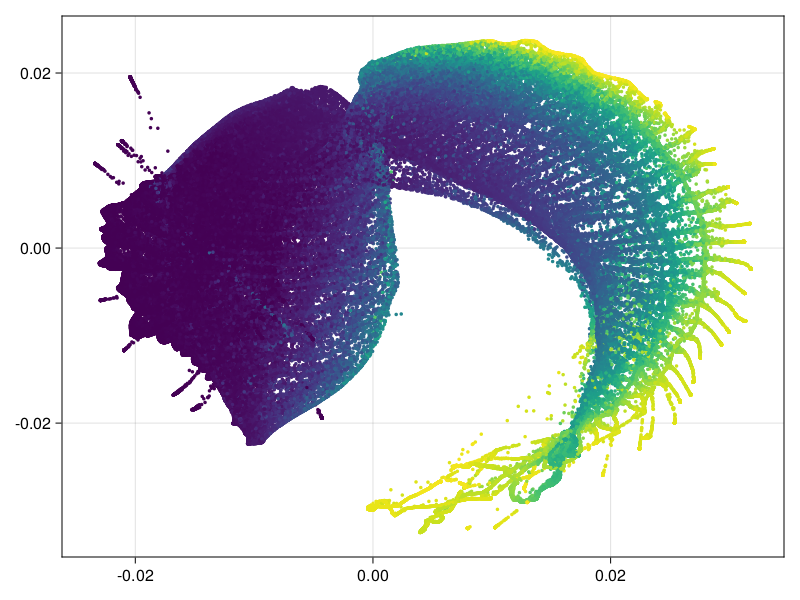

In [21]:
CairoMakie.scatter(phate_pheno_g3,markersize = 5.,color = fitness_colour[unique_pheno_X])

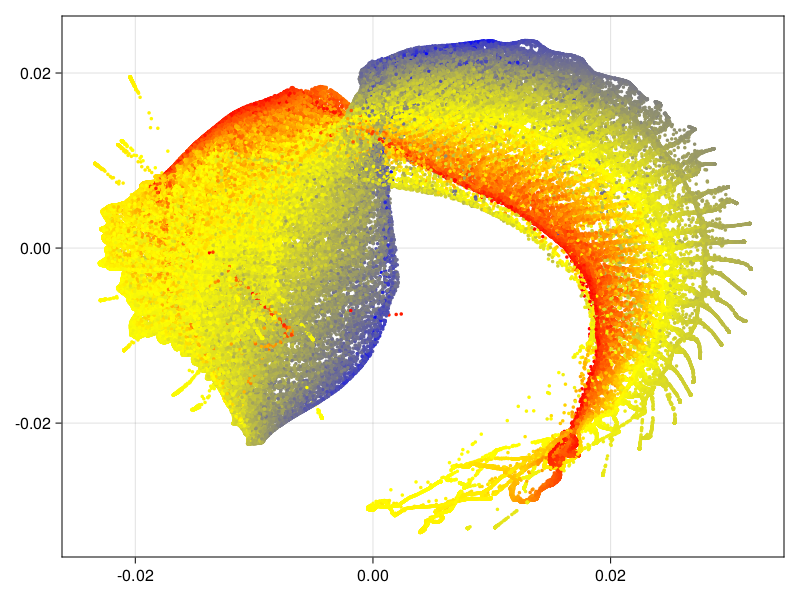

In [22]:
CairoMakie.scatter(phate_pheno_g3,markersize = 5.,color = pheno_width_colour[unique_pheno_X],colormap=cgrad([:red,:yellow,:blue]))

In [23]:
phate_pheno_g12 = phate_op.fit_transform(pheno_g12_X[:,unique_pheno_X] |> transpose |> collect);

In [ ]:
CairoMakie.scatter(phate_pheno_g12,markersize = 5.,color = fitness_colour[unique_pheno_X])

In [ ]:
CairoMakie.scatter(phate_pheno_g12,markersize = 5.,color = pheno_width_colour[unique_pheno_X],colormap=cgrad([:red,:yellow,:blue]))

In [ ]:
phate_op = phate.PHATE(knn = 150, gamma = 0.)

In [ ]:
phate_end_pheno_g12 = phate_op.fit_transform(end_pheno_g12_X |> transpose |> collect);

In [ ]:
CairoMakie.scatter(phate_end_pheno_g12,markersize = 5.)

In [21]:
geno_X = reduce(hcat,gt.traj_m)

unique_geno_X = uniqueidx(geno_X);

In [22]:
end_geno_X = reduce(hcat,map(x->x[:,end],gt.traj_m));

In [29]:
phate_op = phate.PHATE(knn = 1000, gamma = 0.,n_jobs = -2,n_pca = 19,knn_max = 2000, random_state = 99)

PyObject PHATE(gamma=0.0, knn=1000, knn_max=2000, n_jobs=-2, n_pca=19, random_state=99)

In [30]:
phate_geno = phate_op.fit_transform(geno_X[:,unique_geno_X] |> transpose |> collect);

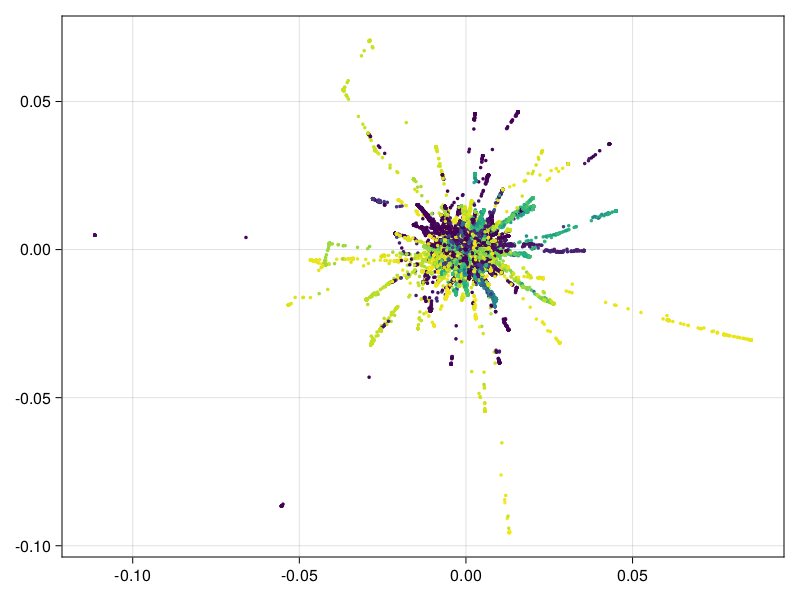

In [28]:
CairoMakie.scatter(phate_geno,markersize = 5.,color = fitness_colour[unique_geno_X])

In [ ]:
phate_end_geno = phate_op.fit_transform(end_geno_X |> transpose |> collect);

In [ ]:
CairoMakie.scatter(phate_end_geno,markersize = 5.)

In [93]:
traj_geno_class = [[geno_assignments[n] for _ in 1:length(t)] for (n,t) in enumerate(gt.traj)]

traj_geno_class_v = reduce(vcat,traj_geno_class )

traj_pheno_class = [[pheno_assignments[n] for _ in 1:length(t)] for (n,t) in enumerate(pt.traj)]

traj_pheno_class_v = reduce(vcat,traj_pheno_class );

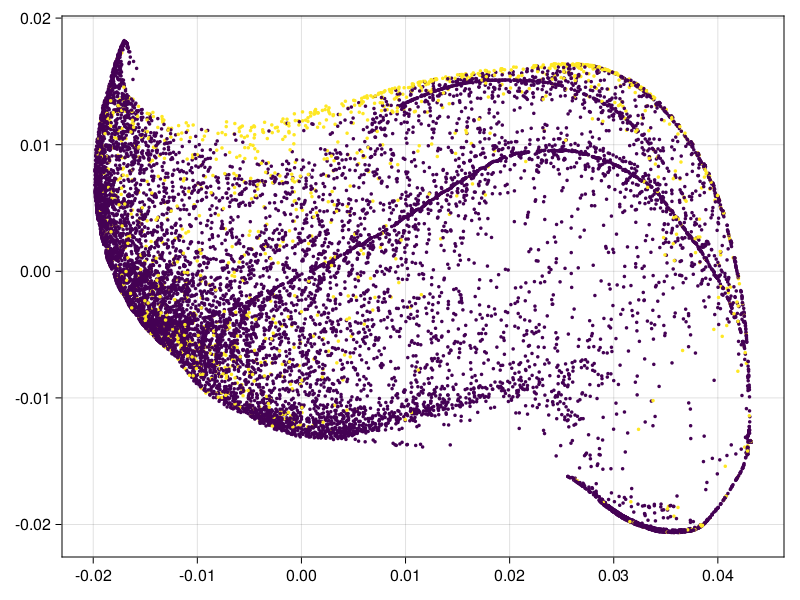

In [94]:
CairoMakie.scatter(phate_pheno_g3,markersize = 5.,color = traj_pheno_class_v[unique_pheno_X])

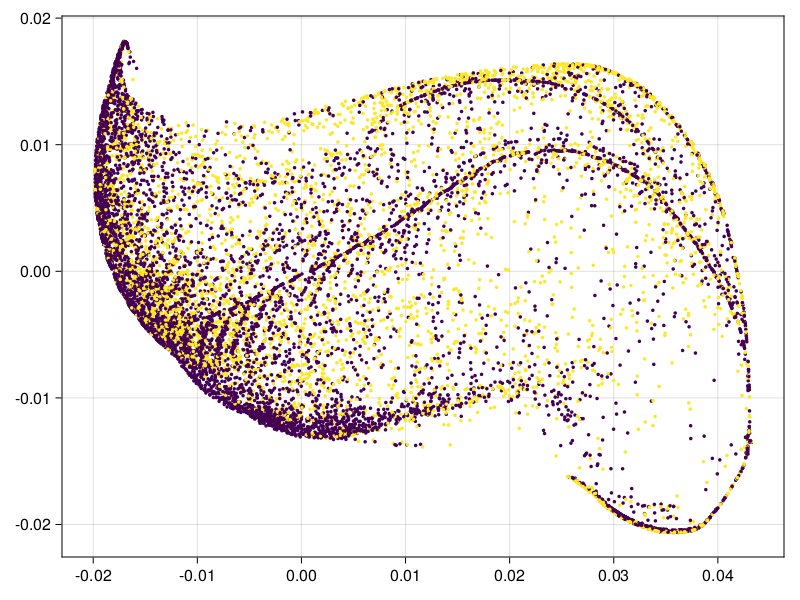

In [95]:
CairoMakie.scatter(phate_pheno_g3,markersize = 5.,color = traj_geno_class_v[unique_pheno_X])

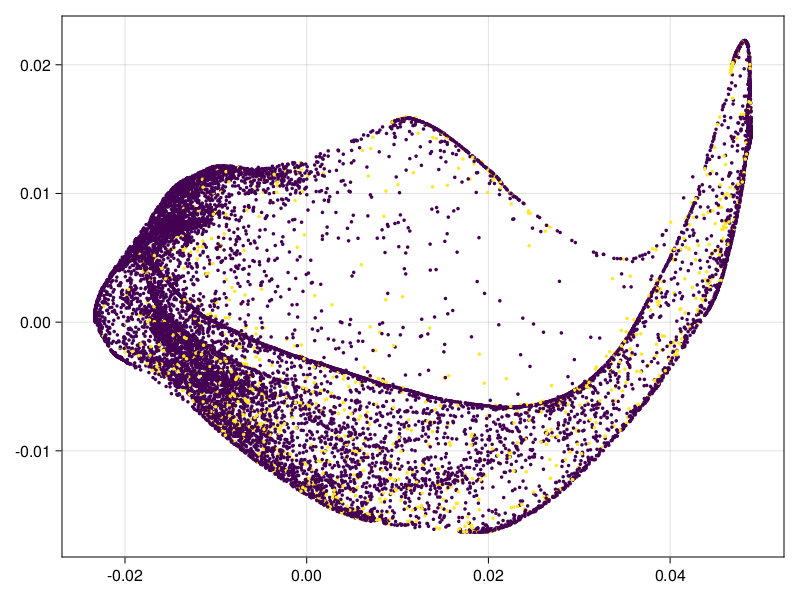

In [96]:
CairoMakie.scatter(phate_pheno_g12,markersize = 5.,color = traj_pheno_class_v[unique_pheno_X])

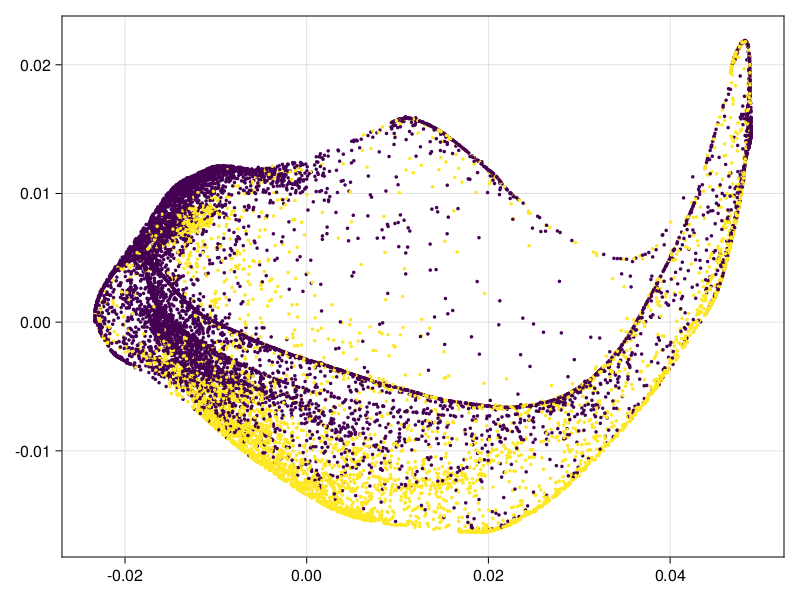

In [97]:
CairoMakie.scatter(phate_pheno_g12,markersize = 5.,color = traj_geno_class_v[unique_pheno_X])

First example of pheno/geno correspondence

In [98]:
geno_cluster_exemplar_choices[1]

2-element Vector{Int64}:
 2068
  439

In [123]:
diff = fill(zeros(12,12),length(geno_cluster_exemplar_choices[1]))

for (i,n) in enumerate(geno_cluster_exemplar_choices[1])
    diff[i] = gt.traj_m[n][:,2:end] .- gt.traj_m[n][:,1:end-1] 
end

In [170]:
function get_path(diff_v,angle_it)
    weight_change_order = mapslices(s->findall(x->x!=0,s),diff_v,dims = 1)[1,:]
    path = [(0.,0.)]
    for (n,wc) in enumerate(weight_change_order)
        θ = angle_it[wc]
        r = diff_v[wc,n]
        push!(path,(r*cos(θ),r*sin(θ)))
    end
    return refresh_type(path)
end

get_path (generic function with 1 method)

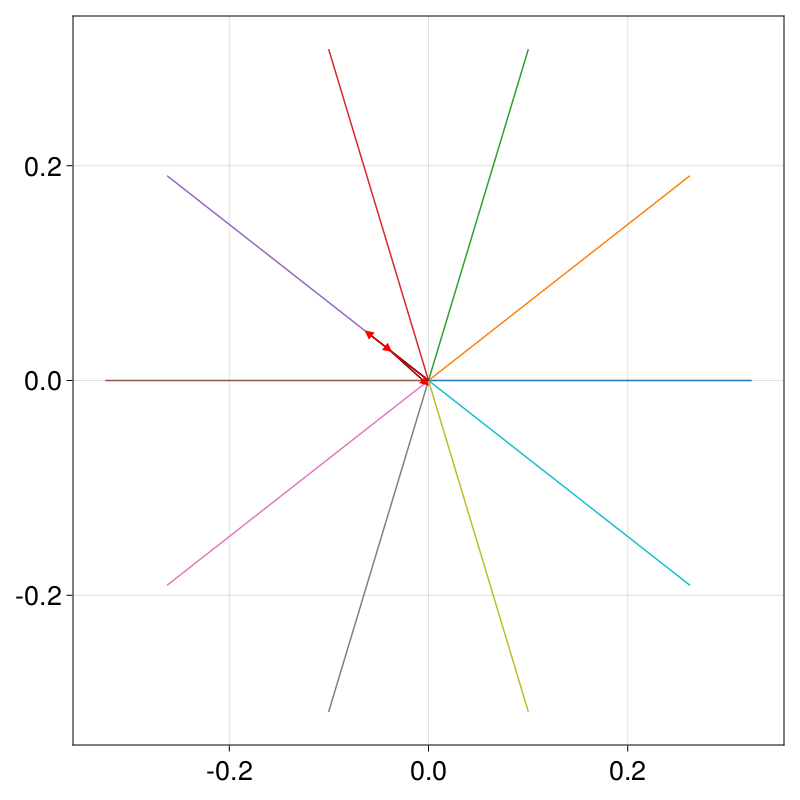

In [179]:
fig = CairoMakie.Figure(resolution = (800, 800),fontsize = 27.)

ax1  = Axis(fig[1,1], backgroundcolor = "white")

r_max = 1.1*maximum(abs.(reduce(hcat,diff)))

color_scheme = palette(:tab10)

traj_color = [:red,:blue]

angle_it = LinRange(0, 2π,11)

for (n,θ) in enumerate(angle_it)

    if n < 11
        CairoMakie.lines!(ax1,[r.*(cos(θ),sin(θ)) for r in LinRange(0, r_max,100)],label = string(n),color = color_scheme[n])
    end

end

for (n,diff_v) in enumerate(diff)

    if n == 1
        path = get_path(diff_v,angle_it)

        CairoMakie.lines!(ax1,path,color = :black)
        CairoMakie.arrows!(ax1,return_arrows(path)...,color = traj_color[n],label = "Trajectory " * string(n))
    end
end


# leg = Legend(fig[1,2],ax1)

fig


In [174]:
using StatsBase

In [175]:
sample(1:10,10,replace = false)

10-element Vector{Int64}:
  8
 10
  6
  2
  9
  1
  5
  3
  4
  7